This file will cover the training and evaluations task, basically covering  the predictions

# Imports and Paths

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Note: These are core sklearn utilities for splitting, scaling, modeling, and evaluation
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, recall_score, precision_score)

# Note: These will be used for handling class imbalance in rare crash events
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = os.getcwd()

# Note: We also need to ensure all paths exist or are created for all directories, will make life easier later
DATA_DIR = os.path.join(BASE_DIR, 'data')
MERGED_DIR = os.path.join(DATA_DIR, 'merged')
MERGED_FILE = os.path.join(MERGED_DIR, 'merged_dataset_cleaned.csv')

# Note: These are for the outputs
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')
PLOTS_DIR = os.path.join(OUTPUT_DIR, 'plots')

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Loading the Dataset, Sorting

Here we will load the dataset and make sure it is sorted for time based analysis

In [4]:
# Note: Load final merged dataset created earlier in the pipeline
df = pd.read_csv(MERGED_FILE)

# Note: Convert date column to datetime for time-series operations
df['date'] = pd.to_datetime(df['date'])

# Note: Sort by date to prevent time leakage
df = df.sort_values('date').reset_index(drop=True)

print("df.shape")
print(f"{df['date'].min()} to {df['date'].max()}")

df.shape
1990-01-02 00:00:00 to 2025-12-09 00:00:00


# Defining the Forward Looking Crash Events

Here, we will create an early warning crash label, and identify whether a major market drop occrus within the next 20 trading days.

In [5]:
# Note: We will compute daily S&P 500 returns
df['sp500_return'] = df['close_sp500'].pct_change()

# Note: This function labels a crash if a severe drop happens in the NEXT 20 days
def detect_crash_forward(df, window=20, threshold=-0.07):
    
    crashes = []
    crash_details = []
    
    for i in range(len(df)):
        if i + window >= len(df):
            crashes.append(np.nan)
            continue
        
        future_returns = df['sp500_return'].iloc[i+1:i+1+window]
        cumulative_return = (1 + future_returns).prod() - 1
        
        # Note: It will also detect sharp short-term drops inside the window
        max_drop_5d = 0
        for j in range(len(future_returns) - 4):
            five_day_return = (1 + future_returns.iloc[j:j+5]).prod() - 1
            max_drop_5d = min(max_drop_5d, five_day_return)
        
        # Note: Define a crash if there is any long drop or a sudden short-term collapse
        if cumulative_return <= threshold or max_drop_5d <= -0.05:
            crashes.append(1)
            if len(crash_details) < 10:
                crash_details.append({
                    'date': df['date'].iloc[i],
                    'cumulative_return': cumulative_return,
                    'worst_5d': max_drop_5d
                })
        else:
            crashes.append(0)
    
    return crashes, crash_details

# Note: Will also apply crash detection logic
df['crash_20d'], crash_details = detect_crash_forward(df, window=20, threshold=-0.07)

# Note: Also remove rows near the end that cannot be labeled
df_model = df[df['crash_20d'].notna()].copy()

print(f"Crash events detected: {int(df_model['crash_20d'].sum())} ({df_model['crash_20d'].mean():.2%})")


Crash events detected: 1202 (13.31%)


# Feature Engineering

Here what we will do is construct technical, volatility, macroeconomic, and stress-related indicators that are used to predict crashes 

In [7]:
# Note: Moving averages will capture trend direction
df_model['ma_10'] = df_model['close_sp500'].rolling(10, min_periods=5).mean()
df_model['ma_20'] = df_model['close_sp500'].rolling(20, min_periods=10).mean()
df_model['ma_50'] = df_model['close_sp500'].rolling(50, min_periods=25).mean()
df_model['ma_200'] = df_model['close_sp500'].rolling(200, min_periods=100).mean()

# Note: This will get the price relative to trend indicators
df_model['price_to_ma10'] = df_model['close_sp500'] / df_model['ma_10']
df_model['price_to_ma20'] = df_model['close_sp500'] / df_model['ma_20']
df_model['price_to_ma50'] = df_model['close_sp500'] / df_model['ma_50']
df_model['price_to_ma200'] = df_model['close_sp500'] / df_model['ma_200']

# Note: We also need trend crossover ratios (death cross / golden cross proxies)
df_model['ma20_ma50_ratio'] = df_model['ma_20'] / df_model['ma_50']
df_model['ma50_ma200_ratio'] = df_model['ma_50'] / df_model['ma_200']

# Note: Volatility helps measures uncertainty and instability
df_model['volatility_5d'] = df_model['sp500_return'].rolling(5, min_periods=3).std()
df_model['volatility_20d'] = df_model['sp500_return'].rolling(20, min_periods=10).std()
df_model['volatility_60d'] = df_model['sp500_return'].rolling(60, min_periods=30).std()

df_model['vol_spike_ratio'] = df_model['volatility_5d'] / df_model['volatility_60d']

# Note: Finally, momentum features capture speed and direction of price changes
df_model['momentum_5'] = df_model['close_sp500'].pct_change(5)
df_model['momentum_10'] = df_model['close_sp500'].pct_change(10)
df_model['momentum_20'] = df_model['close_sp500'].pct_change(20)
df_model['momentum_60'] = df_model['close_sp500'].pct_change(60)

df_model['momentum_acceleration'] = df_model['momentum_5'].diff(5)

# Note: VIX features for fear index
if 'close_vix' in df_model.columns:
    df_model['vix_ma_10'] = df_model['close_vix'].rolling(10, min_periods=5).mean()
    df_model['vix_ma_30'] = df_model['close_vix'].rolling(30, min_periods=15).mean()
    df_model['vix_spike'] = df_model['close_vix'] / df_model['vix_ma_30']
    df_model['vix_change'] = df_model['close_vix'].pct_change(periods=5)
    # VIX above 20 is fear, above 30 is panic
    df_model['vix_high'] = (df_model['close_vix'] > 25).astype(int)

# Note: Yield curve features for recession predictor
if 't10y' in df_model.columns and 't2y' in df_model.columns:
    df_model['yield_curve_10y2y'] = df_model['t10y'] - df_model['t2y']
    df_model['yield_curve_inverted'] = (df_model['yield_curve_10y2y'] < 0).astype(int)
    df_model['yield_curve_steepness'] = df_model['yield_curve_10y2y'].rolling(20, min_periods=10).mean()

if 't10y' in df_model.columns and 't3m' in df_model.columns:
    df_model['yield_curve_10y3m'] = df_model['t10y'] - df_model['t3m']

# Note: Rate change features based on Fed policy
if 'fed_funds_rate' in df_model.columns:
    df_model['fed_rate_change'] = df_model['fed_funds_rate'].diff()
    df_model['fed_rate_change_20d'] = df_model['fed_funds_rate'].diff(20)
    df_model['fed_rate_high'] = (df_model['fed_funds_rate'] > 4).astype(int)

# Note: Credit spread features to measure Financial stress
if 'high_yield_spread' in df_model.columns:
    df_model['credit_spread_ma'] = df_model['high_yield_spread'].rolling(20, min_periods=10).mean()
    df_model['credit_spread_change'] = df_model['high_yield_spread'].diff(5)
    df_model['credit_spread_spike'] = df_model['high_yield_spread'] / df_model['credit_spread_ma']

# Note: These are the macro deterioration features
if 'unemployment' in df_model.columns:
    df_model['unemployment_change'] = df_model['unemployment'].diff()
    df_model['unemployment_change_60d'] = df_model['unemployment'].diff(60)
    df_model['unemployment_rising'] = (df_model['unemployment_change_60d'] > 0.5).astype(int)

if 'cpi' in df_model.columns:
    df_model['cpi_change'] = df_model['cpi'].pct_change(periods=20)

# Note: we also need technical indicators
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=window//2).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=window//2).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_model['rsi_14'] = compute_rsi(df_model['close_sp500'], window=14)
df_model['rsi_oversold'] = (df_model['rsi_14'] < 30).astype(int)
df_model['rsi_overbought'] = (df_model['rsi_14'] > 70).astype(int)

# Note: These are the drawdown features, so how far from peak
df_model['running_max'] = df_model['close_sp500'].rolling(252, min_periods=126).max()  # 1-year
df_model['drawdown'] = (df_model['close_sp500'] - df_model['running_max']) / df_model['running_max']
df_model['deep_drawdown'] = (df_model['drawdown'] < -0.10).astype(int)

# Feature Selection

This next step will be for feature selection. It will narrow the feature set we have to high-signal indicators known to correlate market stress and crash risk

In [8]:
# Note: These features are prioritized based on finance literature and intuition
priority_features = [
    # Note: olatility (MOST IMPORTANT)
    'volatility_5d', 'volatility_20d', 'vol_spike_ratio', 'close_vix', 'vix_spike', 'vix_change', 'vix_high',
    
    # Note: Momentum & trend
    'momentum_5', 'momentum_10', 'momentum_acceleration', 'price_to_ma20', 'price_to_ma50',
    'ma20_ma50_ratio', 'ma50_ma200_ratio',
    
    # Note: Credit & financial stress
    'high_yield_spread', 'credit_spread_change', 'credit_spread_spike', 'stl_fsi',
    
    # Note: Yield curve
    'yield_curve_10y2y', 'yield_curve_inverted', 'yield_curve_10y3m',
    
    # Note: Rates
    'fed_funds_rate', 'fed_rate_change', 'fed_rate_change_20d', 't10y',
    
    # Note: Technical
    'rsi_14', 'rsi_oversold', 'drawdown', 'deep_drawdown',
    
    # Note: Macro
    'unemployment_change', 'unemployment_rising', 'cpi_change'
]

# Note: We will also only keep features that actually exist and contain valid data
available_features = []
for f in priority_features:
    if f in df_model.columns and df_model[f].notna().any():
        available_features.append(f)

print(f"{len(available_features)} high-priority features")

# Note: We will also drop rows that still contain NaNs after feature creation
df_clean = df_model.dropna(subset=available_features + ['crash_20d'])
print(f"{len(df_clean)} rows ({len(df_model) - len(df_clean)} dropped)")

df_model = df_clean
X = df_model[available_features]
y = df_model['crash_20d']
dates = df_model['date']

print(f"Crash events: {int(y.sum())} ({y.mean():.2%})")
print(f"{dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}")

32 high-priority features
7253 rows (1779 dropped)
Crash events: 1153 (15.90%)
1997-01-14 to 2025-11-10


# Time-Based Train/Test Split

This step will help simulate the real-world deployment, it wil lensure the model only trains on past data

In [9]:
# Note: We are using 80% of the data for training and the rest for testing, so a standard 80/20 split
split_date = df_model['date'].quantile(0.8)
train_mask = df_model['date'] < split_date
test_mask = df_model['date'] >= split_date

# Note: We are splitting the data into training and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"Training: {len(X_train)} samples, {y_train.sum()} crashes ({y_train.mean():.2%})")
print(f"Test: {len(X_test)} samples, {y_test.sum()} crashes ({y_test.mean():.2%})")

Training: 5802 samples, 904.0 crashes (15.58%)
Test: 1451 samples, 249.0 crashes (17.16%)


# Handling Class Imbalance with SMOTE

In [12]:
# Note: We are combining SMOTE with Tomek links
# Note: This will help reduce noisy synthetic samples and improve model performance
try:
    smote_tomek = SMOTETomek(random_state=42)
    X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_train, y_train)
    print(f"SMOTE-Tomek")
except:
    # Note: If SMOTE-Tomek fails, we will use regular SMOTE
    smote = SMOTE(random_state=42, k_neighbors=3)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print(f"SMOTE")

print(f"Training set after balancing: {len(X_train_balanced)} samples, {y_train_balanced.sum()} crashes ({y_train_balanced.mean():.2%})")

# Note: As with any task, need to standardize features for best model performance so that it treats all inputs similarly

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

SMOTE-Tomek
Training set after balancing: 9722 samples, 4861.0 crashes (50.00%)


# Training the cost-sensitive models

In this step, what we will do is we will train multiple models while penalizing any missed crashes

In [13]:
# Note: Here we will calculate class weights (penalize missing crashes heavily)
crash_weight = len(y_train) / (2 * y_train.sum())
no_crash_weight = len(y_train) / (2 * (len(y_train) - y_train.sum()))
class_weights = {0: no_crash_weight, 1: crash_weight * 3}  \
# Note: We have kept a 3x penalty for missing crashes, and that is because missing a crash is 
# far worse than any false alarms

print(f"Class weights: No-Crash {no_crash_weight:.2f}, Crash {class_weights[1]:.2f}")

# Note: First is Logistic Regression
# Note: It will serve as an interpretable baseline, and help us set a threshold for the later models
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(
    max_iter=2000,
    random_state=42,
    class_weight=class_weights,
    C=0.5,
    solver='saga'
)
lr_model.fit(X_train_scaled, y_train_balanced)
print("Logistic Regression done")

# Note: Next model is Gradient Boosting and that is because it is a powerful 
# method that can handle complex interactions and non-linear relationships
print("\nTraining Gradient Boosting...")
gb_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=42
)
# Note: Here we will apply sample weights to penalize crash misclassification
sample_weights = np.where(y_train_balanced == 1, crash_weight * 3, no_crash_weight)
gb_model.fit(X_train_scaled, y_train_balanced, sample_weight=sample_weights)
print("Gradient Boosting done")

# Note: Next model is Random Forest and that is because it is a powerful 
# method that can handle complex interactions and non-linear relationships
# Note: It is also a good choice for this problem because it is less prone to overfitting
# Note: It also adds robustness and variance reduction and has good interpretability
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=15,
    min_samples_leaf=8,
    max_features='sqrt',
    random_state=42,
    class_weight=class_weights
)
rf_model.fit(X_train_scaled, y_train_balanced)
print("Random Forest done")

Class weights: No-Crash 0.59, Crash 9.63

Training Logistic Regression...
Logistic Regression done

Training Gradient Boosting...
Gradient Boosting done

Training Random Forest...
Random Forest done


# Predictions, but Recall-Optimized

This step creates an ensemble and it will tune the alert threshold to prioritize crash detection

In [14]:
# Note: We will use a weighted ensemble of the three models
lr_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
gb_proba = gb_model.predict_proba(X_test_scaled)[:, 1]
rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Note: This is the weighted ensemble where we are favoring GB and RF
ensemble_proba = (lr_proba * 0.2 + gb_proba * 0.4 + rf_proba * 0.4)

# Note: Here we will find the optimal threshold that maximizes recall while maintaining reasonable precision
best_threshold = 0.3
best_score = 0

# Note: Here we will iterate over the threshold values and find the optimal one
# Note: We will prioritize recall (weight it 2x) over precision
for thresh in np.arange(0.15, 0.50, 0.05):
    pred_temp = (ensemble_proba >= thresh).astype(int)
    if y_test.sum() > 0:
        recall = recall_score(y_test, pred_temp)
        precision = precision_score(y_test, pred_temp) if pred_temp.sum() > 0 else 0
        # Note: Like said before, prioritize recall (weight it 2x)
        score = 2 * recall + precision
        
        tp = ((pred_temp == 1) & (y_test == 1)).sum()
        fp = ((pred_temp == 1) & (y_test == 0)).sum()
        fn = ((pred_temp == 0) & (y_test == 1)).sum()
        
        print(f"Threshold {thresh:.2f}: Recall={recall:.2%}, Precision={precision:.2%}, TP={tp}, FP={fp}, FN={fn}")
        
        if score > best_score and recall >= 0.50:  # Note: Require at least 50% recall
            best_score = score
            best_threshold = thresh

print(f"\nOptimal threshold: {best_threshold:.2f}")

# Note: We will use the optimal threshold to make the final predictions
lr_pred = (lr_proba >= best_threshold).astype(int)
gb_pred = (gb_proba >= best_threshold).astype(int)
rf_pred = (rf_proba >= best_threshold).astype(int)
ensemble_pred = (ensemble_proba >= best_threshold).astype(int)

print(f"\nFinal predictions:")
print(f"Predicted crashes: {ensemble_pred.sum()}/{len(ensemble_pred)}")
print(f"Actual crashes: {y_test.sum()}/{len(y_test)}")
print(f"True Positives: {((ensemble_pred == 1) & (y_test == 1)).sum()}")
print(f"False Negatives: {((ensemble_pred == 0) & (y_test == 1)).sum()}")
print(f"Recall: {recall_score(y_test, ensemble_pred):.2%}")

Threshold 0.15: Recall=93.57%, Precision=17.04%, TP=233, FP=1134, FN=16
Threshold 0.20: Recall=86.35%, Precision=16.98%, TP=215, FP=1051, FN=34
Threshold 0.25: Recall=76.71%, Precision=17.41%, TP=191, FP=906, FN=58
Threshold 0.30: Recall=65.06%, Precision=17.40%, TP=162, FP=769, FN=87
Threshold 0.35: Recall=54.62%, Precision=17.04%, TP=136, FP=662, FN=113
Threshold 0.40: Recall=47.79%, Precision=16.74%, TP=119, FP=592, FN=130
Threshold 0.45: Recall=44.58%, Precision=17.00%, TP=111, FP=542, FN=138

Optimal threshold: 0.15

Final predictions:
Predicted crashes: 1367/1451
Actual crashes: 249.0/1451
True Positives: 233
False Negatives: 16
Recall: 93.57%


# Evaluating the Model

In this step we wille valuatate each model with metrics that are focused on crash detection quality

In [17]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred) if y_pred.sum() > 0 else 0
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print(f"Model: {model_name}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Recall (Crash Detection Rate): {recall:.2%}T")
    print(f"Precision: {precision:.2%}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:")
    print(f"True Negatives (Correct no-crash): {tn}")
    print(f"False Positives (False alarms): {fp}")
    print(f"False Negatives (Missed crashes): {fn}")
    print(f"True Positives (Caught crashes): {tp}")
    
    if y_true.sum() > 0:
        print(f"\n  Crash Detection: Caught {tp}/{int(y_true.sum())} crashes ({recall:.1%})")

evaluate_model(y_test, lr_pred, lr_proba, "Logistic Regression")
evaluate_model(y_test, gb_pred, gb_proba, "Gradient Boosting")
evaluate_model(y_test, rf_pred, rf_proba, "Random Forest")
evaluate_model(y_test, ensemble_pred, ensemble_proba, "Ensemble we created")

Model: Logistic Regression
ROC-AUC: 0.4900
Recall (Crash Detection Rate): 99.60%T
Precision: 17.10%
F1 Score: 0.2919
Confusion Matrix:
True Negatives (Correct no-crash): 0
False Positives (False alarms): 1202
False Negatives (Missed crashes): 1
True Positives (Caught crashes): 248

  Crash Detection: Caught 248/249 crashes (99.6%)
Model: Gradient Boosting
ROC-AUC: 0.4872
Recall (Crash Detection Rate): 36.14%T
Precision: 14.29%
F1 Score: 0.2048
Confusion Matrix:
True Negatives (Correct no-crash): 662
False Positives (False alarms): 540
False Negatives (Missed crashes): 159
True Positives (Caught crashes): 90

  Crash Detection: Caught 90/249 crashes (36.1%)
Model: Random Forest
ROC-AUC: 0.5351
Recall (Crash Detection Rate): 89.96%T
Precision: 17.06%
F1 Score: 0.2868
Confusion Matrix:
True Negatives (Correct no-crash): 113
False Positives (False alarms): 1089
False Negatives (Missed crashes): 25
True Positives (Caught crashes): 224

  Crash Detection: Caught 224/249 crashes (90.0%)
Model

# Visualization

This step is to produce the plots for interpretability and presentation

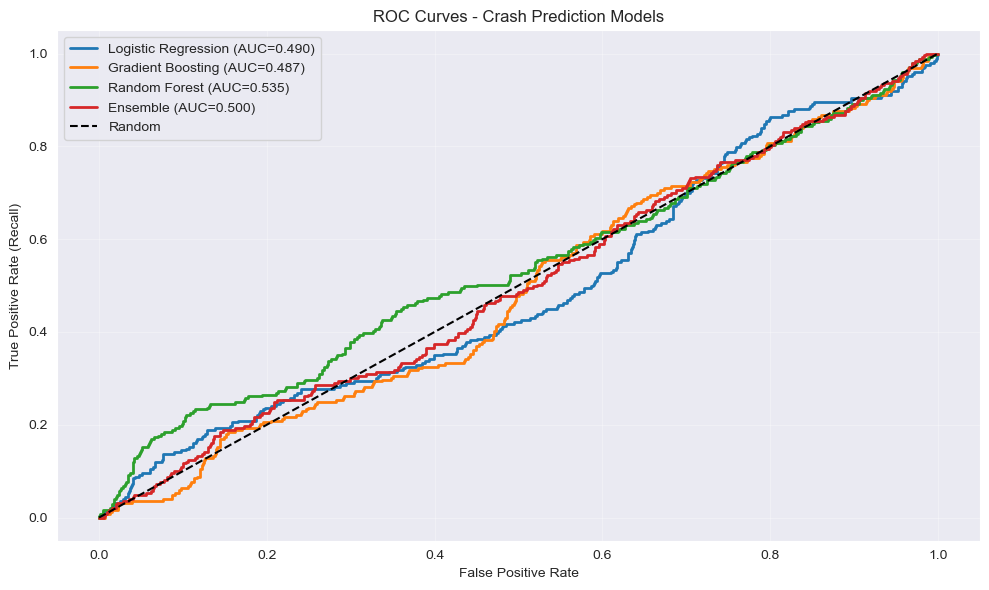

ROC curves saved


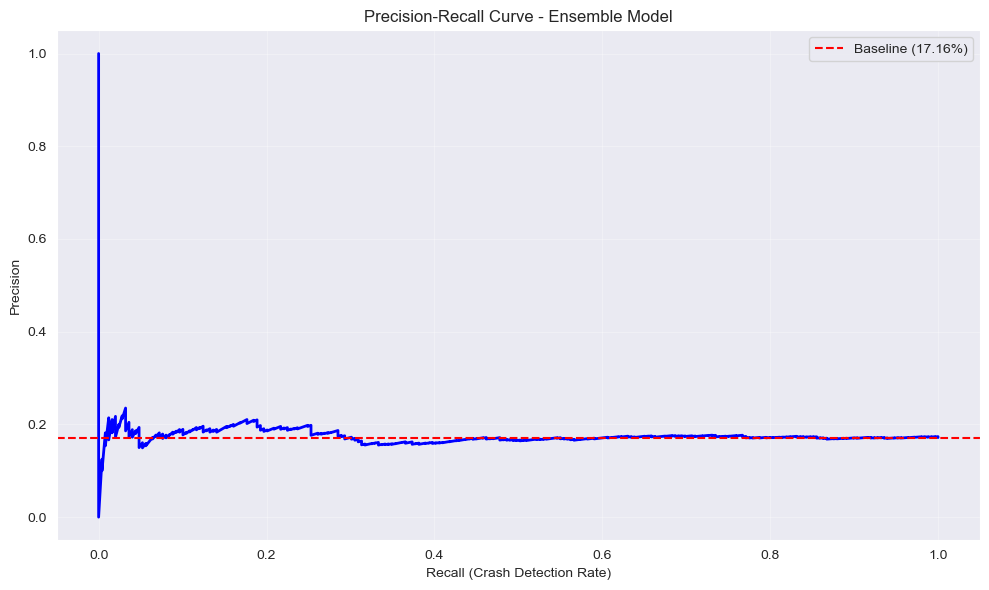

Precision-Recall curve saved


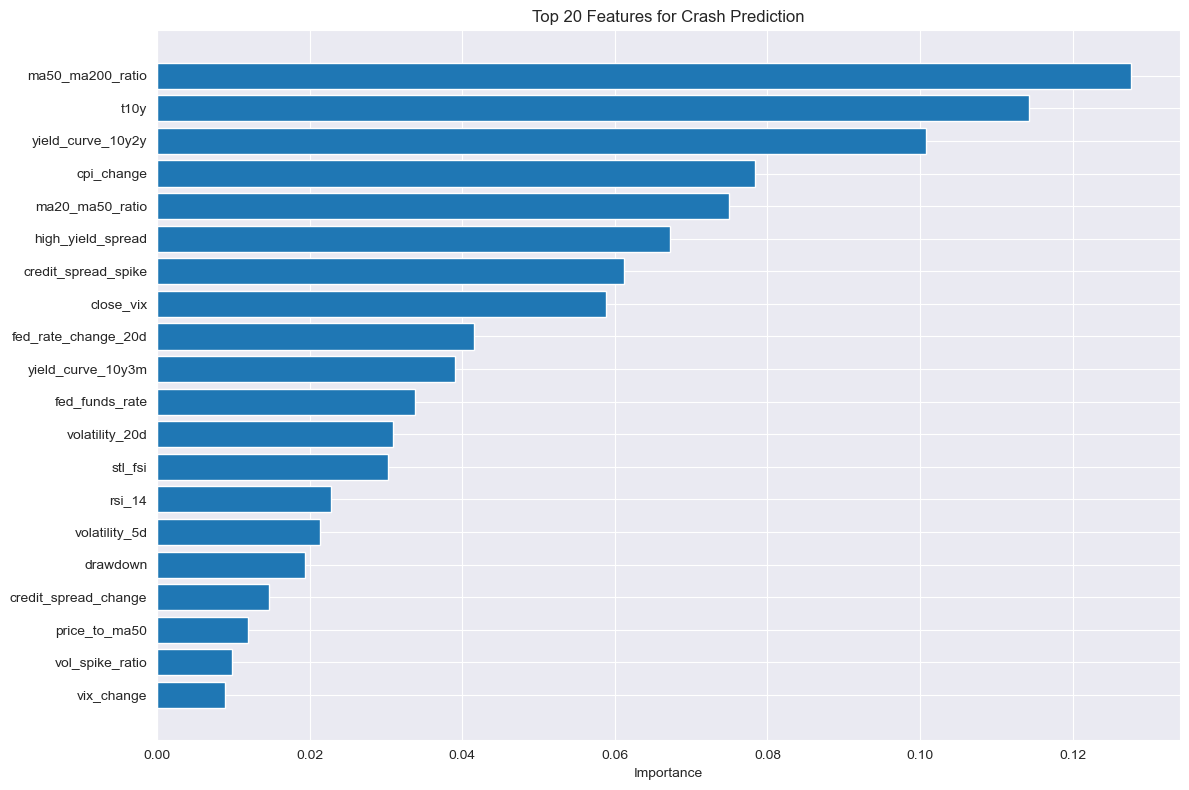

Feature importance saved


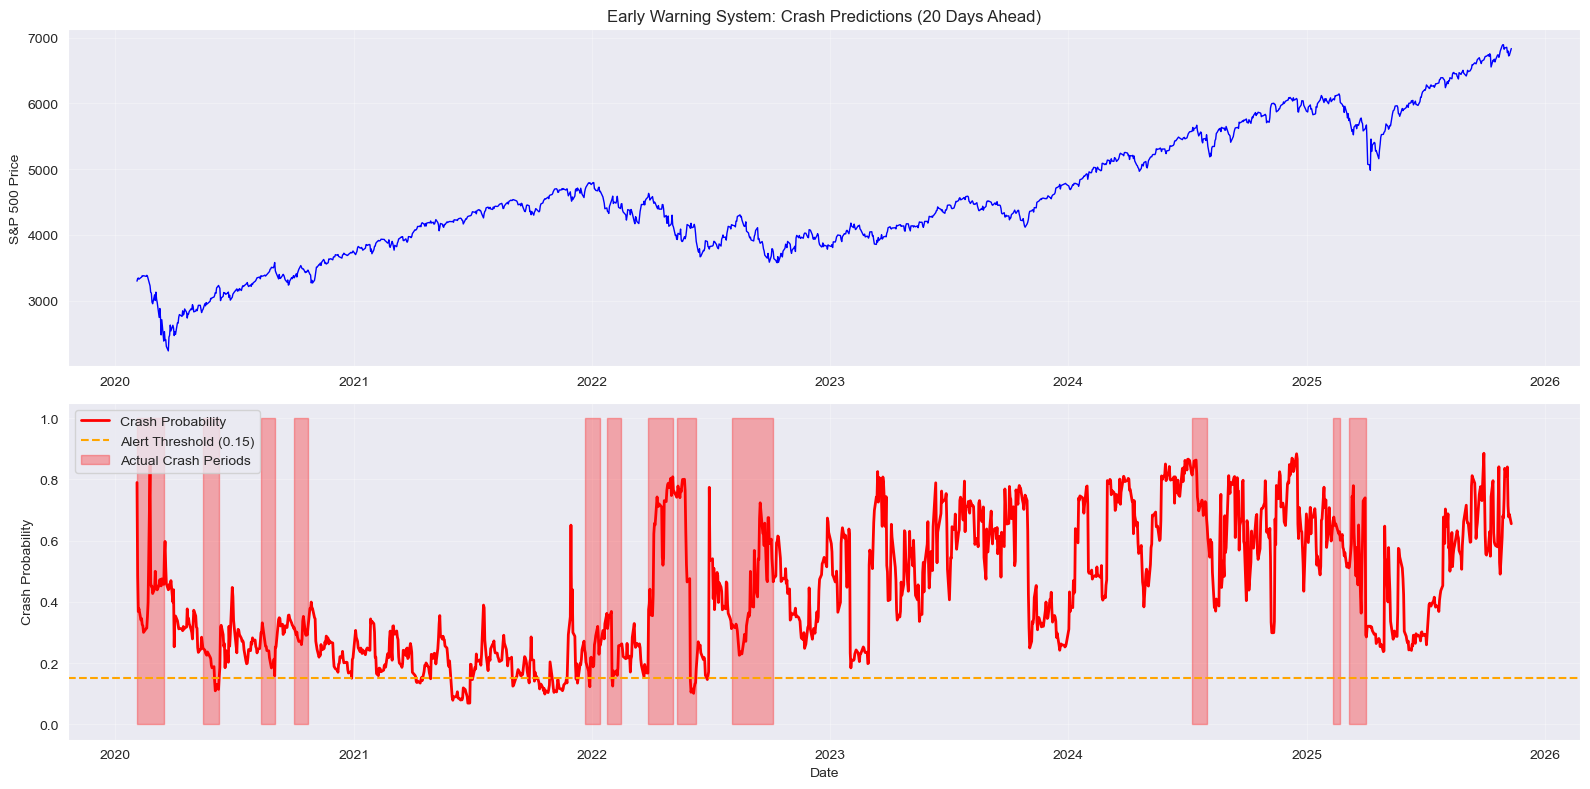

Timeline saved


In [18]:
# Note: ROC Curves
plt.figure(figsize=(10, 6))
for name, proba in [('Logistic Regression', lr_proba), ('Gradient Boosting', gb_proba),
                     ('Random Forest', rf_proba), ('Ensemble', ensemble_proba)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves - Crash Prediction Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'roc_curves_improved.png'), dpi=300)
plt.show()
print("ROC curves saved")

# Note: Precision-Recall Curve
plt.figure(figsize=(10, 6))
precision_vals, recall_vals, _ = precision_recall_curve(y_test, ensemble_proba)
plt.plot(recall_vals, precision_vals, linewidth=2, color='blue')
plt.xlabel('Recall (Crash Detection Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble Model')
plt.grid(True, alpha=0.3)
plt.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Baseline ({y_test.mean():.2%})')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'precision_recall.png'), dpi=300)
plt.show()
print("Precision-Recall curve saved")

# Note: Feature Importance
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': gb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top 20 Features for Crash Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'feature_importance_improved.png'), dpi=300)
plt.show()
print("Feature importance saved")

# Note: Prediction Timeline
plt.figure(figsize=(16, 8))
test_df = df_model[test_mask].copy()

ax1 = plt.subplot(2, 1, 1)
ax1.plot(test_df['date'], test_df['close_sp500'], color='blue', linewidth=1)
ax1.set_ylabel('S&P 500 Price')
ax1.set_title('Early Warning System: Crash Predictions (20 Days Ahead)')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
ax2.plot(test_df['date'].values, ensemble_proba, color='red', linewidth=2, label='Crash Probability')
ax2.axhline(y=best_threshold, color='orange', linestyle='--', label=f'Alert Threshold ({best_threshold:.2f})')
ax2.fill_between(test_df['date'].values, 0, 1, where=(y_test.values == 1), 
                  alpha=0.3, color='red', label='Actual Crash Periods')
ax2.set_ylabel('Crash Probability')
ax2.set_xlabel('Date')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, 'prediction_timeline_improved.png'), dpi=300)
plt.show()
print("Timeline saved")

# Saving the Results

This step saves predictions and trained models for reproducibility

In [19]:
results_df = pd.DataFrame({
    'date': dates[test_mask].values,
    'actual_crash_20d': y_test.values,
    'ensemble_probability': ensemble_proba,
    'ensemble_prediction': ensemble_pred,
    'alert': (ensemble_proba >= best_threshold).astype(int),
    'sp500_close': df_model.loc[test_mask, 'close_sp500'].values,
})

results_path = os.path.join(OUTPUT_DIR, 'crash_predictions_improved.csv')
results_df.to_csv(results_path, index=False)
print(f"Results: {results_path}")

# Note: Save models
import pickle
with open(os.path.join(MODELS_DIR, 'improved_ensemble_model.pkl'), 'wb') as f:
    pickle.dump({
        'lr_model': lr_model, 'gb_model': gb_model, 'rf_model': rf_model,
        'scaler': scaler, 'features': available_features,
        'threshold': best_threshold
    }, f)
print(f"Models: {MODELS_DIR}")

Results: /Users/aaryabratc/Desktop/WASHU MAIN/FALL 2025/cse3104_Data_Manipulation_and_Management/Project/project_code/output/crash_predictions_improved.csv
Models: /Users/aaryabratc/Desktop/WASHU MAIN/FALL 2025/cse3104_Data_Manipulation_and_Management/Project/project_code/output/models
